# Boundary conditions

In [1]:
include("smij-functions.jl");

Some more adventures in boundary conditions.

## Superposition

For a linear problem

$$
Lu &= f, \quad \text{in} \Omega, \\ 
Bu &= g, \quad \text{on} \partial \Omega, 
$$

where $L$ and $B$ are linear operators, you can solve the pair of problems

$$
Lv &= f, \quad Bv = 0 \\ 
Lw &= 0, \quad Bw = g. 
$$

Then by linearity, $u = v+w$. 

For example, to solve $\partial_{xx} = e^{4x}$ subject to $u(-1)=0$, $u(1)=1$, we first note that the linear function $\tfrac{1}{2}(x+1)$ satisfies the boundary conditions and has a zero second derivative. So we can add it to a solution of the ODE with homogeneous boundary conditions.

### p32: solve $\partial_{xx}u = e^{4x}, \quad u(-1)=0, \; u(1)=1$ (compare p13)

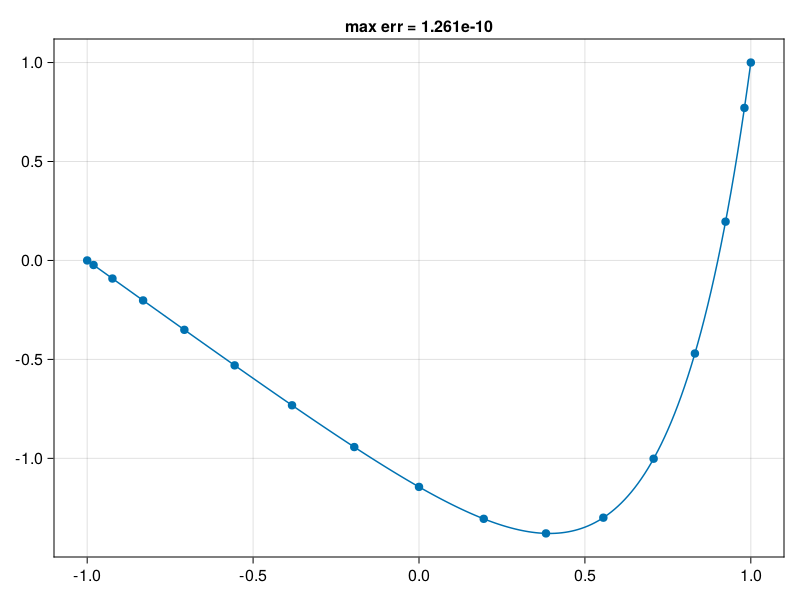

In [2]:
N = 16
D, x = cheb(N)
D² = (D^2)[2:N, 2:N]
f = @. exp(4 * x[2:N])
u = D² \ f                           # Poisson eq. solved here
u = [0; u; 0] + (x .+ 1) / 2

using CairoMakie, PyFormattedStrings
fig, ax, _ = scatter(x, u)
xx = -1:0.01:1
uu = polyinterp(x,u).(xx)
lines!(xx, uu)
exact = @. (exp(4xx) - sinh(4)*xx - cosh(4)) / 16 + (xx + 1) / 2
ax.title = f"max err = {norm(uu - exact,Inf):.4g}"
fig

## Neumann condition

Remember, we can replace a row of a discretization of the ODE at all the grid points with a row of the boundary operator, and make a corresponding change to the forcing vector.

### p33: solve linear BVP $\partial_{xx} = e^{4x},\; u'(-1)=u(1)=0$

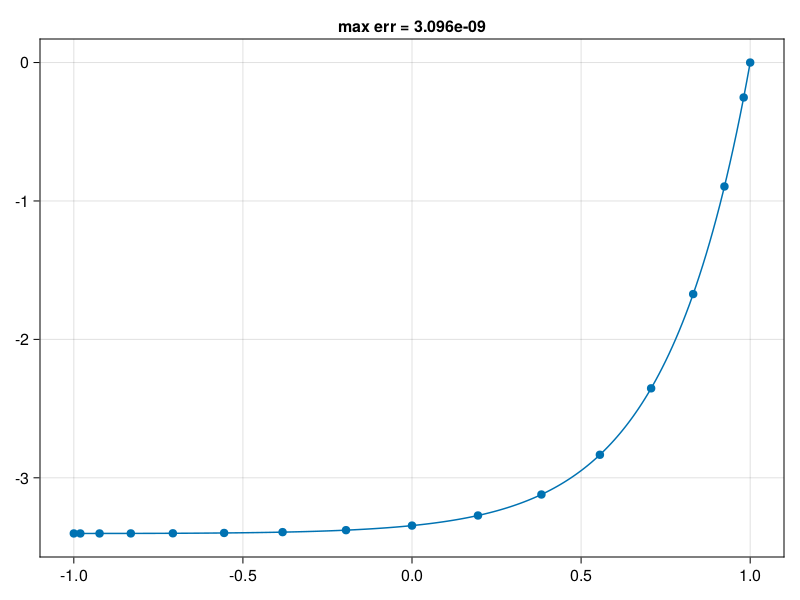

In [3]:
N = 16
D, x = cheb(N)
A = D^2
A[N+1, :] = D[N+1, :]            # Neumann condition at x = -1
A = A[2:N+1, 2:N+1]
f = @. exp(4 * x[2:N])
u = A \ [f; 0]
u = [0; u]

fig, ax, _ = scatter(x, u)
# axis([-1, 1, -4, 0])
xx = -1:0.01:1
uu = polyinterp(x,u).(xx)
lines!(xx, uu)
exact = @. (exp(4xx) - 4exp(-4) * (xx - 1) - exp(4)) / 16
ax.title = f"max err = {norm(uu - exact, Inf):.4g}"
fig

## Time-dependent condition

The **Allen--Cahn** equation is the PDE

$$
\partial_t = \epsilon \partial_{xx} u + u - u^3. 
$$

There are three steady, constant solutions at $u=0$ and $u=\pm 1$. Ignoring the diffusion term, the interior state is unstable and the others are stable; in general, the solution prefers being at $u=\pm 1$ for large regions, with rapid transitions between them. 


We start with the steady conditions $u(-1)=-1$, $u(1)=1$. Note the metastable evolution as the solution slowly approaches minimal number of transitions between stable states.


# p34 - Allen-Cahn eq., $u(-1)=-1$, $u(1)=1$

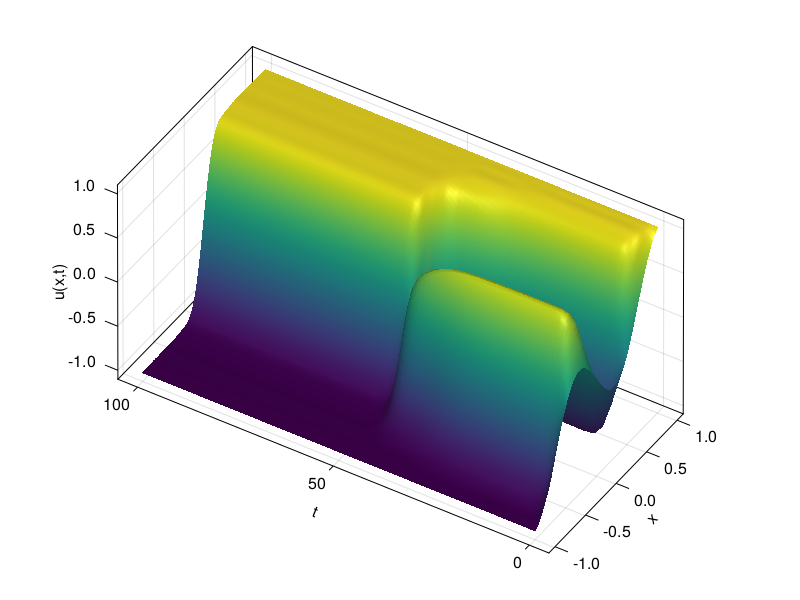

In [4]:
using OrdinaryDiffEq

# Differentiation matrix and initial data:
N = 20
D, x = cheb(N)
D² = (D^2)[2:N, :]
u₀ = @. 0.53x + 0.47sin(-1.5*π*x)

extend(t,v) = [1; v; -1]

function allencahn(u,ε,t)
    du = ε*D²*extend(t,u)
    @. du += u - u^3
    return du
end

ivp = ODEProblem(allencahn, u₀[2:N], (0., 100.), 0.01)
sol = solve(ivp, Rodas5())

using CairoMakie
t = range(0, 100, 80)
xx = range(-1, 1, 80)
u = t -> polyinterp(extend(t,sol(t))).(xx)
U = hcat( [u(t) for t in t]... )
fig = Figure()
ax = Axis3(fig[1, 1], 
    aspect=(1,2,1), azimuth=3.7, elevation=0.7,
    xlabel="x", ylabel="t", zlabel="u(x,t)"
    )
surface!(xx,t,U)
fig

Now consider the boundary conditions

$$
u(-1,t) = -1, \quad u(1,t) = 1 + \sin^2(t/5).
$$

We can apply these simply by changing the definition of the `extend` function.

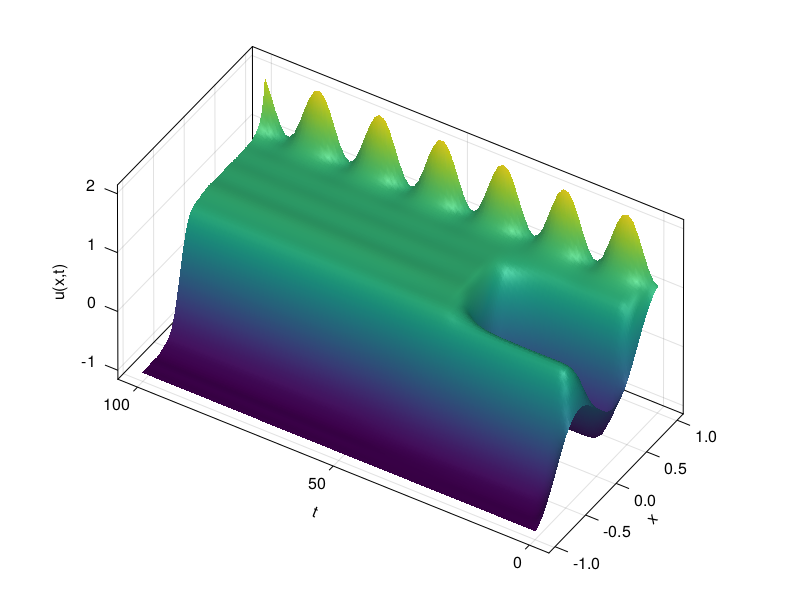

In [5]:
extend(t,v) = [1 + sin(t/5)^2; v; -1]
sol = solve(ivp, Rodas5())

using CairoMakie
t = range(0, 100, 80)
xx = range(-1, 1, 80)
u = t -> polyinterp(extend(t,sol(t))).(xx)
U = hcat( [u(t) for t in t]... )
fig = Figure()
ax = Axis3(fig[1, 1], 
    aspect=(1,2,1), azimuth=3.7, elevation=0.7,
    xlabel="x", ylabel="t", zlabel="u(x,t)"
    )
surface!(xx,t,U)
fig

## Two space dimensions

Same techniques apply to Laplace's equation, say with boundary conditions

$$
u(x,y) = \begin{cases} 
\sin^4(\pi x), & y = 1 \text{ and } -1 < x < 0, \\ 
\frac{1}{5} \sin(3\pi y), & x=1 \\ 
0, & \text{otherwise}.
\end{cases}
$$

### p36: Laplace eq. with nonzero BCs

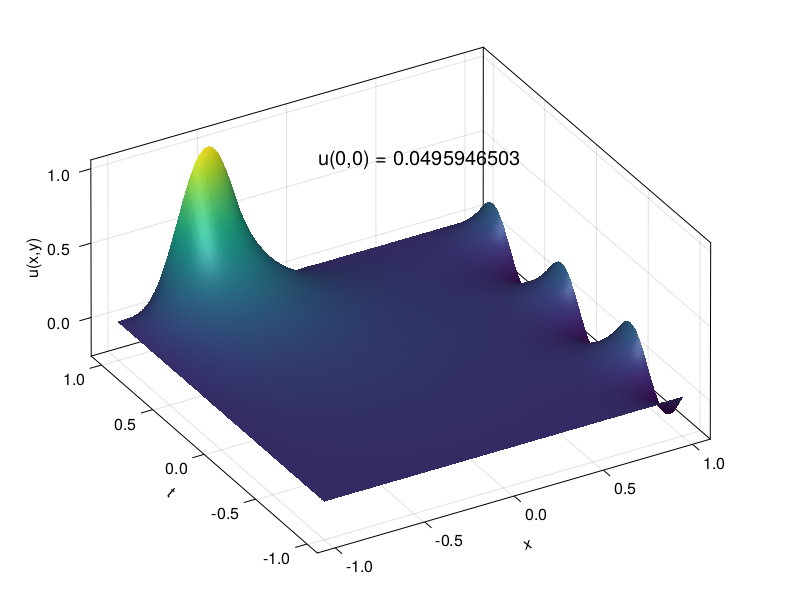

In [6]:
# Set up grid and 2D Laplacian, boundary points included:
N = 24
⊗ = kron
D, y = D, x = cheb(N)
D² = D^2
L = I(N+1) ⊗ D² + D² ⊗ I(N+1)

# Impose boundary conditions by replacing appropriate rows of L:
X = [ x for x in x, y in y ]
Y = [ y for x in x, y in y ]
bdy = vec(@. abs(X)==1 || abs(Y)==1) 
bdy1 = vec(@. Y==1 && -1 < X < 0)
bdy2 = vec(@. X==1)

L[bdy, :] .= I((N+1)^2)[bdy, :]
f = zeros((N+1)^2)
f[bdy1] = @. sin(π*X[bdy1])^4
f[bdy2] = @. 0.2sin(3π*Y[bdy2])

# Solve Laplace equation, reshape to 2D, and plot:
u = L \ f
U = reshape(u, N+1, N+1)
xx = yy = range(-1, 1, 80)
UU = gridinterp(U, xx, yy)

fig = Figure()
ax = Axis3(fig[1, 1], 
    aspect=(2,2,1), azimuth=12π/9, elevation=π/6,
    xlabel="x", ylabel="t", zlabel="u(x,y)"
    )
surface!(xx, yy, UU)
umid = U[N÷2 + 1, N÷2 + 1]
text!(0, 0.8, 0.8, text=f"u(0,0) = {umid:.10f}")
fig

## Wave equation in 2D

Finally, let's consider

$$
\partial_{tt} u = \partial_{xx} u + \partial_{yy} u, 
\quad x \in [-3,3], \; y \in [-1,1]. 
$$

If we have Neumann conditions in $y$,

$$
\partial_y u(x,\pm1,t) = 0, 
$$

and periodic conditions in $x$,

$$
u(x,y,t) = u(x+6,y,t),
$$

then the natural choice is a hybrid Chebyshev--Fourier method. 

In order to implement the Neumann conditions, we prefer not to use a DAE, since the wave equation is nonstiff and can use an explicit method in time. So we will remove the boundary nodes from the discretization and implicitly define the values there by the Neumann conditions. Suppose that $\bfu$ represents a vector of all $Ny+1$ values along a line of constant $x$. Then the Neumann conditions are

$$
\bfzero = \bfE \bfD_y \bfu = \begin{bmatrix}
  \bfA & \bfB 
\end{bmatrix}  \begin{bmatrix}
  \bfE \bfu \\ \bfv 
\end{bmatrix},
$$

where $\bfE$ comprises the first and last rows of an $(N_y+1)$-dimension identity matrix, and $\bfv$ is the part of $\bfu$ excluding the endpoints. Thus,

$$
\bfE \bfu = (- \bfA^{-1} \bfB ) \bfv, 
$$

which shows how to recover the endpoint values given the interior ones. 

A note about the code below is that the `OrdinaryDiffEq` package can solve IVPs where the dependent variable is a matrix, which saves us from having to reshape the matrices representing $u$ and $\partial_t u$ into and out of a single vector.

### p37: 2D "wave tank" with Neumann BCs for |y|=1

In [7]:
# x variable in [-A,A], Fourier:
A = 3
Nx = 50
x, Dx, Dxx = trig(Nx)
x = @. (A/π)*x - A
Dxx *= (π/A)^2      # chain rule

# y variable in [-1,1], Chebyshev:
Ny = 15
Dy, y = cheb(Ny)
Dyy = Dy^2

ends = [1, Ny+1]
endvals = -Dy[ends, ends] \ Dy[ends,2:Ny]

chop(U) = U[:, 2:Ny]
function extend(V)
    Uy = V*endvals'
    return [Uy[:,1] V Uy[:,2]]
end

function waveeqn(W, p, t)
    V, Vₜ = W[1:Nx,:], W[Nx+1:2Nx,:]
    U = extend(V)
    Uₜₜ = Dxx*U + U*Dyy'
    return vcat(Vₜ, chop(Uₜₜ))
end

# Grid and initial data:
U = [ exp(-8 * ((x + 1.5)^2 + y^2)) for x in x, y in y ]
Uₜ = -Dx*U

W₀ = [chop(U); chop(Uₜ)]
ivp = ODEProblem(waveeqn, W₀, (0.,4.))
sol = solve(ivp, Tsit5());

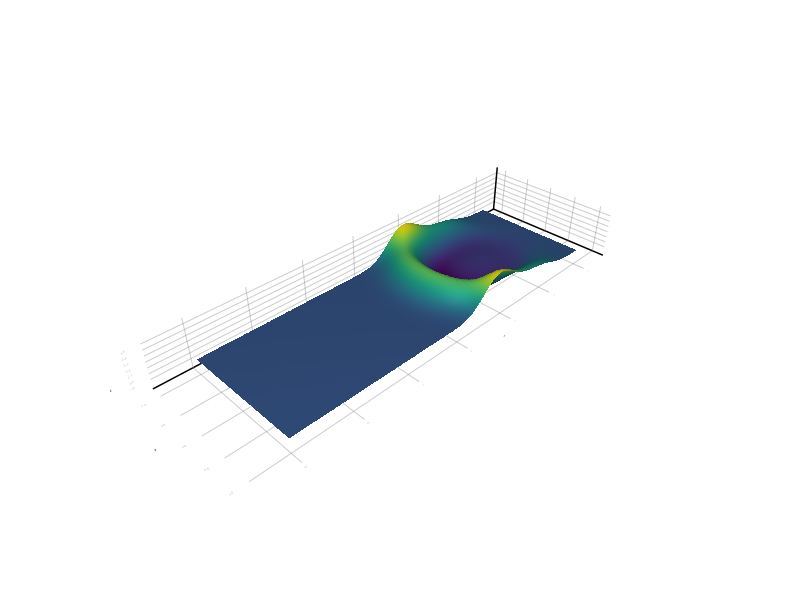

In [8]:
function interp(sol,t,xx,yy)
    V = sol(t)[1:Nx,:]
    U = extend(V)
    U1 = zeros(length(xx), Ny+1)
    xx = @. π/A * (xx + A)
    for j in axes(U,2)
        U1[:,j] = triginterp(U[:,j]).(xx)
    end
    UU = zeros(length(xx),length(yy))
    for i in axes(U1,1)
        UU[i,:] = polyinterp(U1[i,:]).(yy)
    end
    return UU
end

xx = range(-3, 3, 100)
yy = range(-1, 1, 65)
surface(xx, yy, interp(sol, 1, xx, yy))
    

In [9]:
fig = Figure(size=(480,320))
ax = Axis3(fig[1, 1], aspect=(3, 1, 2),
    xlabel="x", ylabel="y", zlabel="u",
    azimuth = 1.3π
)

time = Observable(0.0)
UU = @lift( interp(sol, $time, xx, yy) )
surface!(xx, yy, UU, colormap=:bluesreds, colorrange=(-2.5,2.5) )
record(fig, "p37.mp4", range(0, 4, 101)) do t
    time[] = t
    ax.title = f"t = {t:.2f}"
    zlims!(ax, -2.5, 2.5)
end;

<video autoplay controls><source src="p37.mp4" type="video/mp4"></video>